1) Simulando una serie de tiempo ARIMA(1,0,2) con tendencia y estacionalidad...


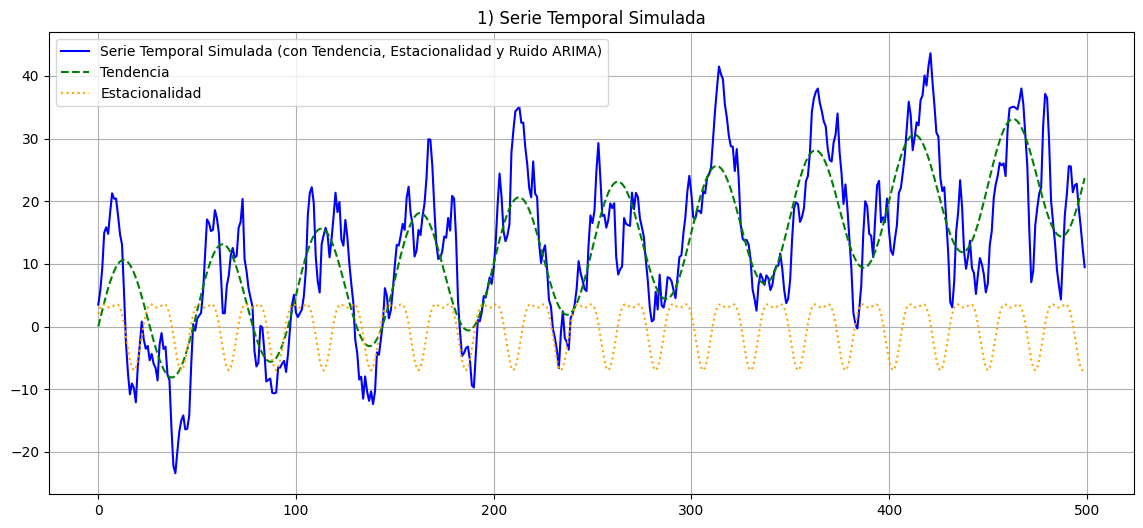


2) Quitando tendencia y estacionalidad usando descomposición STL...
Usando seasonal_param = 25 para STL decomposition.


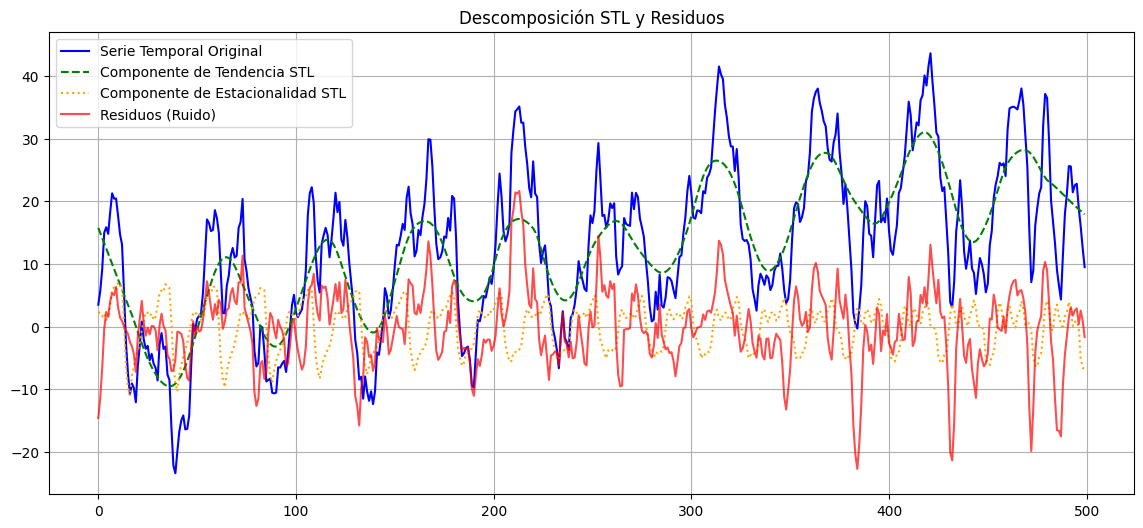


3) Definiendo k grupos Mondrian usando una taxonomía basada en el residuo anterior...
Taxonomía Mondrian (basada en el residuo anterior):
Primeros 10 residuos (sin el primero): [-11.37  -6.48  -0.41   2.34   1.53   4.03   5.3    5.02   6.31   3.08]
Categorías asignadas (sin el primero): [3 3 3 4 2 2 2 2 2 1]
  Categoría 1: 64 residuos
  Categoría 2: 171 residuos
  Categoría 3: 59 residuos
  Categoría 4: 205 residuos

3.5) Revisando la correlación de los residuos dentro de cada grupo y aplicando el test de Ljung-Box...

--- Test de Ljung-Box para TODOS los Residuos (Global, lags=30) ---
       lb_stat      lb_pvalue
30  1220.93431  8.839055e-238
El test de Ljung-Box RECHAZA la hipótesis nula de no autocorrelación. Los residuos globales NO son IID.

--- Test de Ljung-Box por Categoría Mondrian ---
Categoría 1 (n=64, lags=6):
     lb_stat  lb_pvalue
6  25.912537   0.000231
  El test de Ljung-Box RECHAZA la hipótesis nula de no autocorrelación en la Categoría 1. NO son IID.
Categoría 2 (n

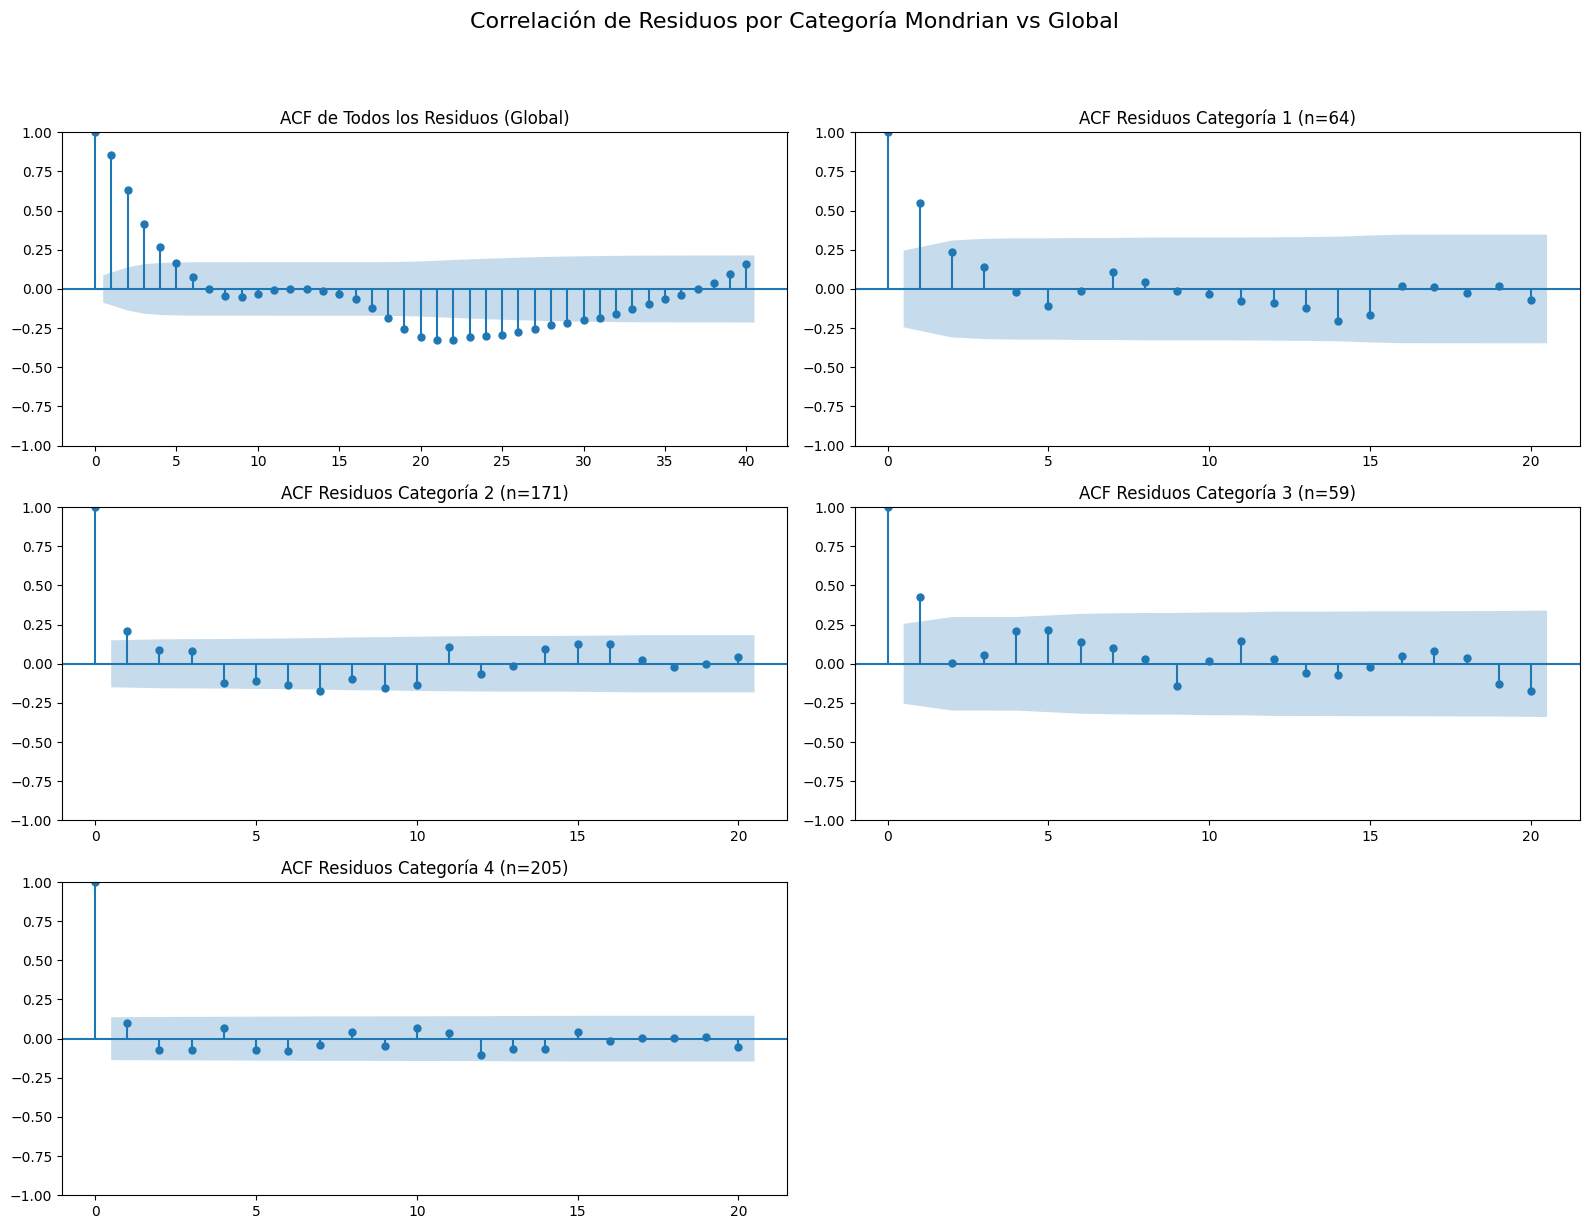


--- Análisis de correlación de grupos ---
Idealmente, las ACF de los residuos dentro de cada categoría Mondrian deberían mostrar una correlación significativamente menor (más cerca de ruido blanco) que la ACF de todos los residuos combinados. Los p-valores del test de Ljung-Box para cada categoría deberían ser mayores a 0.05 para indicar que los residuos dentro de esos grupos pueden considerarse IID.

4) Aplicando la metodología Mondrian para obtener la distribución predictiva...
El último residuo real es: -1.68
La categoría Mondrian para el siguiente punto (basada en el último real) es: 4

5) Generando la distribución predictiva final para el siguiente tiempo (CDF y PDF)...


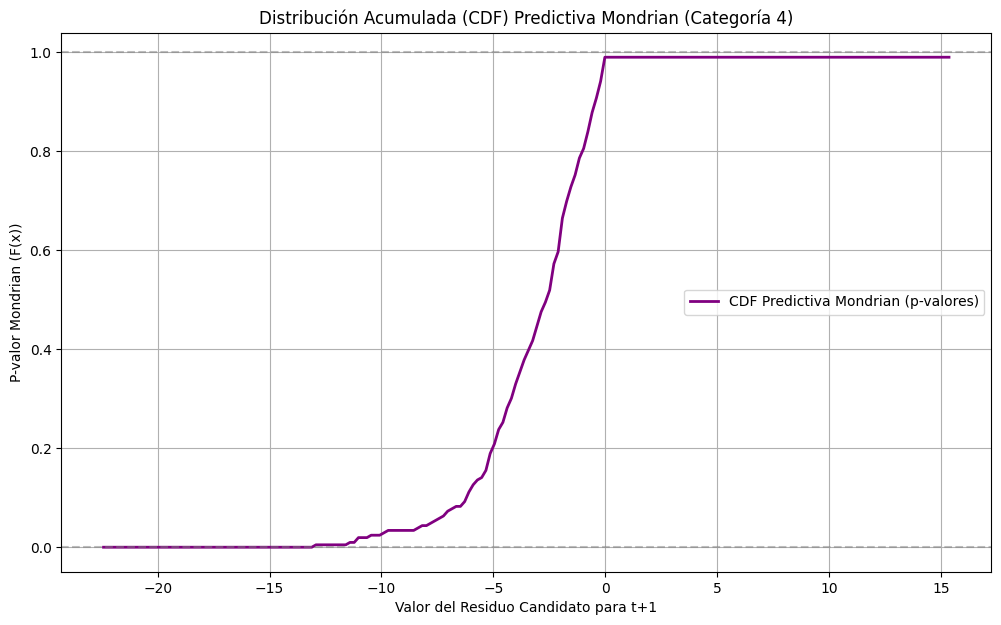

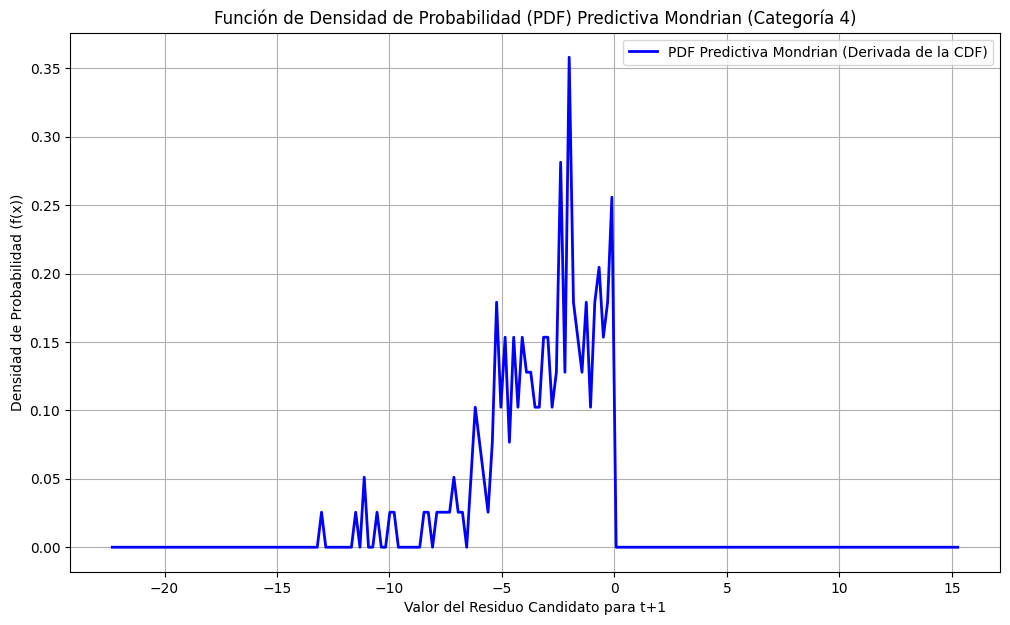


Intervalo de Predicción Mondrian (Nivel de Confianza 95%) para el siguiente residuo:
[-10.05, -0.08]


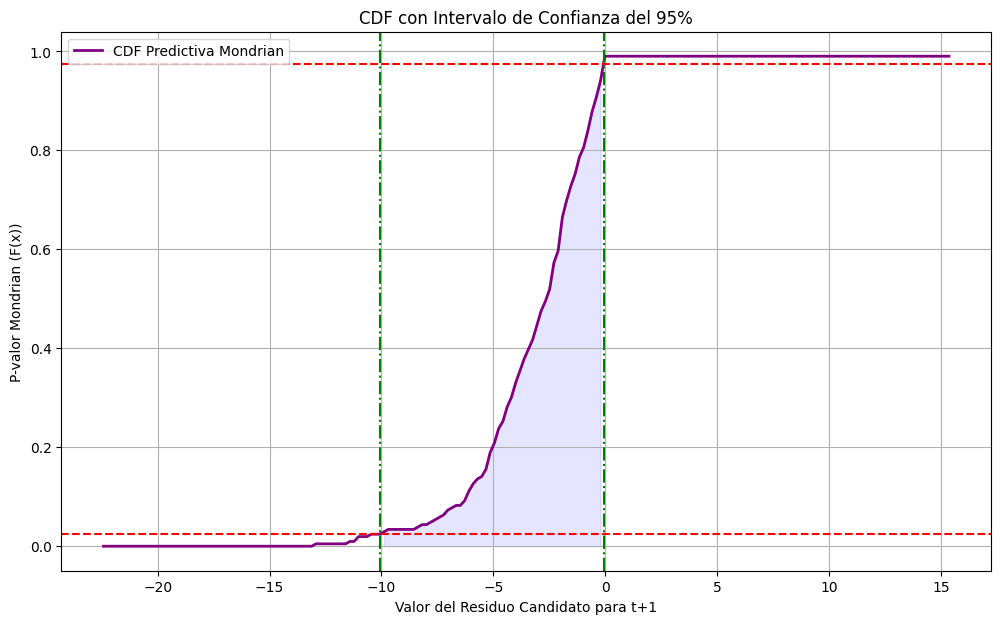

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox # Para el test de Ljung-Box
from scipy.stats import uniform
import scipy.signal
import warnings

# Suprimir advertencias para una salida más limpia
warnings.filterwarnings("ignore")

# 1) Simular una serie de tiempo ARIMA(1,0,2) con tendencia y estacionalidad

np.random.seed(42)
n_points = 500
freq = 24 # Frecuencia diaria (e.g., datos horarios para un día)
seasonal_period = freq # Período estacional (un ciclo diario)

print("1) Simulando una serie de tiempo ARIMA(1,0,2) con tendencia y estacionalidad...")

# 1.1) Generar tendencia
time = np.arange(n_points)
trend = 0.05 * time + np.sin(time / 50 * 2 * np.pi) * 10

# 1.2) Generar estacionalidad
seasonal_pattern = np.array([np.sin(2 * np.pi * i / freq) * 5 + np.cos(4 * np.pi * i / freq) * 2 for i in range(freq)])
seasonality = np.tile(seasonal_pattern, n_points // freq + 1)[:n_points]

# 1.3) Generar ruido ARIMA(1,0,2)
# Coeficiente AR(1): phi = 0.7
# Coeficientes MA(1) y MA(2): theta1 = 0.5, theta2 = 0.3
# Generamos ruido blanco y luego lo pasamos por los filtros ARMA.
white_noise = np.random.normal(loc=0, scale=3, size=n_points)

# Coeficientes para el filtro (usando scipy.signal.lfilter)
# Para ARMA(p,q): y[n] = b[0]*x[n] + ... + b[q]*x[n-q] - a[0]*y[n-1] - ... - a[p-1]*y[n-p]
# En statsmodels.tsa.arima.model.ARIMA, los coeficientes AR tienen signo positivo,
# así que para 'lfilter' se usan con signo negativo para el lado AR del filtro.
ar_coeffs_filter = np.r_[1, -0.7] # [1, -phi_1]
ma_coeffs_filter = np.r_[1, 0.5, 0.3] # [1, theta_1, theta_2]
arima_noise = scipy.signal.lfilter(ma_coeffs_filter, ar_coeffs_filter, white_noise)

# Combinar componentes para la serie de tiempo final
time_series = trend + seasonality + arima_noise

plt.figure(figsize=(14, 6))
plt.plot(time_series, label='Serie Temporal Simulada (con Tendencia, Estacionalidad y Ruido ARIMA)', color='blue')
plt.plot(trend, label='Tendencia', linestyle='--', color='green')
plt.plot(seasonality, label='Estacionalidad', linestyle=':', color='orange')
plt.legend()
plt.title('1) Serie Temporal Simulada')
plt.grid(True)
plt.show()

# 2) Quitar tendencia y estacionalidad

print("\n2) Quitando tendencia y estacionalidad usando descomposición STL...")

# CORRECCIÓN: `seasonal` debe ser un entero positivo impar >= 3
if seasonal_period % 2 == 0:
    stl_seasonal_param = seasonal_period + 1 
else:
    stl_seasonal_param = seasonal_period

if stl_seasonal_param < 3:
    stl_seasonal_param = 3 # Valor mínimo permitido

print(f"Usando seasonal_param = {stl_seasonal_param} para STL decomposition.")

stl = STL(time_series, seasonal=stl_seasonal_param, period=seasonal_period, robust=True)
res = stl.fit()

residuals = res.resid

plt.figure(figsize=(14, 6))
plt.plot(time_series, label='Serie Temporal Original', color='blue')
plt.plot(res.trend, label='Componente de Tendencia STL', linestyle='--', color='green')
plt.plot(res.seasonal, label='Componente de Estacionalidad STL', linestyle=':', color='orange')
plt.plot(residuals, label='Residuos (Ruido)', color='red', alpha=0.7)
plt.legend()
plt.title('Descomposición STL y Residuos')
plt.grid(True)
plt.show()

# Eliminar los valores NaN que puedan aparecer al inicio/final de los residuos por la descomposición STL
residuals = residuals[~np.isnan(residuals)]

if len(residuals) < 2: # Necesitamos al menos 2 residuos para definir categorías basadas en el residuo anterior
    raise ValueError("No hay suficientes residuos después de la descomposición para el análisis Mondrian.")

# 3) Definir los k grupos por medio de un clasificador (Taxonomía Mondrian)

print("\n3) Definiendo k grupos Mondrian usando una taxonomía basada en el residuo anterior...")

# Vamos a usar una taxonomía Mondrian simple basada en:
# 1. El signo del residuo ANTERIOR
# 2. Si su magnitud es "alta" o "baja" respecto a un umbral (e.g., la desviación estándar)
# Esto crea 4 categorías:
# Categoría 1: residuo_anterior > 0 y abs(residuo_anterior) > threshold
# Categoría 2: residuo_anterior > 0 y abs(residuo_anterior) <= threshold
# Categoría 3: residuo_anterior <= 0 y abs(residuo_anterior) > threshold
# Categoría 4: residuo_anterior <= 0 y abs(residuo_anterior) <= threshold

# Calcular el umbral de magnitud (e.g., la desviación estándar de los residuos)
magnitude_threshold = np.std(residuals)

# Asignar categorías a cada residuo basándose en el residuo ANTERIOR
# El residuo `residuals[i]` se categoriza usando `residuals[i-1]`
categories = np.zeros(len(residuals), dtype=int)

# El primer residuo (en el índice 0) no tiene un residuo anterior para la clasificación
# En la práctica Mondrian, los puntos que no pueden ser categorizados de forma consistente
# según la taxonomía (por falta de datos previos) se manejan por separado o se excluyen.
# Para el cálculo de p-valores, solo consideraremos `residuals` desde el índice 1,
# donde `categories[i]` se basará en `residuals[i-1]`.
categories[0] = -1 # Categoría especial para el primer punto, que será ignorado en el Mondrian real

for i in range(1, len(residuals)):
    prev_resid = residuals[i-1]
    
    is_positive = prev_resid > 0
    is_high_magnitude = np.abs(prev_resid) > magnitude_threshold

    if is_positive and is_high_magnitude:
        categories[i] = 1
    elif is_positive and not is_high_magnitude:
        categories[i] = 2
    elif not is_positive and is_high_magnitude:
        categories[i] = 3
    else: # not is_positive and not is_high_magnitude
        categories[i] = 4

# Filtrar residuos y categorías para el análisis Mondrian (ignorar categories[0] == -1)
mondrian_residuals = residuals[categories != -1]
mondrian_categories = categories[categories != -1]

print(f"Taxonomía Mondrian (basada en el residuo anterior):")
print(f"Primeros 10 residuos (sin el primero): {mondrian_residuals[:10].round(2)}")
print(f"Categorías asignadas (sin el primero): {mondrian_categories[:10]}")
unique_cats = np.unique(mondrian_categories)
for cat_id in unique_cats:
    print(f"  Categoría {cat_id}: {np.sum(mondrian_categories == cat_id)} residuos")


# 3.5) Revisar qué tan correlacionados quedan los grupos y Test de Ljung-Box

print("\n3.5) Revisando la correlación de los residuos dentro de cada grupo y aplicando el test de Ljung-Box...")

plt.figure(figsize=(16, 12))

# ACF de todos los residuos (para comparación)
plt.subplot(3, 2, 1)
plot_acf(residuals, lags=40, ax=plt.gca(), title='ACF de Todos los Residuos (Global)')
plt.tight_layout()

# Test de Ljung-Box para todos los residuos
# Usaremos un número de lags significativo, por ejemplo, el 10% del número de puntos o hasta 30
lags_to_test = min(int(len(residuals) * 0.1), 30)
if lags_to_test < 1: lags_to_test = 1 # Asegurarse de tener al menos 1 lag para el test
ljungbox_global_test = acorr_ljungbox(residuals, lags=[lags_to_test], return_df=True)
print(f"\n--- Test de Ljung-Box para TODOS los Residuos (Global, lags={lags_to_test}) ---")
print(ljungbox_global_test)
if ljungbox_global_test['lb_pvalue'].iloc[0] < 0.05:
    print("El test de Ljung-Box RECHAZA la hipótesis nula de no autocorrelación. Los residuos globales NO son IID.")
else:
    print("El test de Ljung-Box NO RECHAZA la hipótesis nula de no autocorrelación. Los residuos globales podrían ser IID.")


# ACFs y Test de Ljung-Box por categoría Mondrian
print("\n--- Test de Ljung-Box por Categoría Mondrian ---")
for i, cat_id in enumerate(unique_cats):
    cat_residuals = mondrian_residuals[mondrian_categories == cat_id]
    
    if len(cat_residuals) > 10: # Necesitamos suficientes puntos para calcular la ACF y el test
        ax = plt.subplot(3, 2, i + 2) # Ajustar para 4 categorías + global
        plot_acf(cat_residuals, lags=min(20, len(cat_residuals)//2 - 1), ax=ax, title=f'ACF Residuos Categoría {cat_id} (n={len(cat_residuals)})')
        
        # Test de Ljung-Box para los residuos de la categoría
        lags_cat_test = min(int(len(cat_residuals) * 0.1), 10) # Menos lags para grupos más pequeños
        if lags_cat_test >= 1:
            ljungbox_cat_test = acorr_ljungbox(cat_residuals, lags=[lags_cat_test], return_df=True)
            print(f"Categoría {cat_id} (n={len(cat_residuals)}, lags={lags_cat_test}):")
            print(ljungbox_cat_test)
            if ljungbox_cat_test['lb_pvalue'].iloc[0] < 0.05:
                print(f"  El test de Ljung-Box RECHAZA la hipótesis nula de no autocorrelación en la Categoría {cat_id}. NO son IID.")
            else:
                print(f"  El test de Ljung-Box NO RECHAZA la hipótesis nula de no autocorrelación en la Categoría {cat_id}. Podrían ser IID.")
        else:
            print(f"  No hay suficientes lags para el test de Ljung-Box en la Categoría {cat_id}.")
    else:
        print(f"Advertencia: No hay suficientes residuos en la categoría {cat_id} para plotear la ACF o realizar el test de Ljung-Box.")

plt.suptitle('Correlación de Residuos por Categoría Mondrian vs Global', y=1.02, fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.98]) # Ajustar layout para el título superior
plt.show()

print("\n--- Análisis de correlación de grupos ---")
print("Idealmente, las ACF de los residuos dentro de cada categoría Mondrian deberían mostrar una correlación significativamente menor (más cerca de ruido blanco) que la ACF de todos los residuos combinados. Los p-valores del test de Ljung-Box para cada categoría deberían ser mayores a 0.05 para indicar que los residuos dentro de esos grupos pueden considerarse IID.")


# 4) Aplicar la metodología Mondrian para obtener la distribución predictiva

print("\n4) Aplicando la metodología Mondrian para obtener la distribución predictiva...")

# Queremos predecir el residuo en el tiempo n_points (el siguiente)
# La categoría de este siguiente punto se basará en el ÚLTIMO residuo conocido
last_actual_resid = mondrian_residuals[-1] # Último residuo real disponible
# La categoría del último residuo real (mondrian_categories[-1]) se basó en residuals[-2]
# Para el siguiente punto (t+1), su categoría se determina usando last_actual_resid (residuals[-1])
is_positive_next_point = last_actual_resid > 0
is_high_magnitude_next_point = np.abs(last_actual_resid) > magnitude_threshold

if is_positive_next_point and is_high_magnitude_next_point:
    next_point_category = 1
elif is_positive_next_point and not is_high_magnitude_next_point:
    next_point_category = 2
elif not is_positive_next_point and is_high_magnitude_next_point:
    next_point_category = 3
else: # not is_positive_next_point and not is_high_magnitude_next_point
    next_point_category = 4

print(f"El último residuo real es: {last_actual_resid:.2f}")
print(f"La categoría Mondrian para el siguiente punto (basada en el último real) es: {next_point_category}")

# Seleccionar los residuos históricos que pertenecen a esta categoría para la predicción
historical_residuals_in_next_category = mondrian_residuals[mondrian_categories == next_point_category]

if len(historical_residuals_in_next_category) < 2: # Necesitamos al menos 2 puntos (1 para comparar, 1 para la N_effective)
    print(f"Advertencia: No hay suficientes residuos históricos ({len(historical_residuals_in_next_category)}) en la categoría {next_point_category} para formar una distribución Mondrian significativa.")
    print("La distribución predictiva será muy incierta o vacua. Se usará un rango por defecto y p-valores planos.")
    candidate_residuals = np.linspace(-10, 10, 100) # Rango por defecto
    p_values_for_plot = np.full_like(candidate_residuals, 0.5) # Valores planos por defecto
else:
    # Definir la medida de no conformidad: simplemente el valor absoluto del residuo
    def nonconformity_measure(resid):
        return np.abs(resid)

    # Generar un rango de valores candidatos para el siguiente residuo
    # Estos valores representan el eje 'y' de la distribución predictiva
    min_res_cat = np.min(historical_residuals_in_next_category)
    max_res_cat = np.max(historical_residuals_in_next_category)
    
    # Expandir el rango un poco para ver la "cola"
    # Asegurarse de que min_res_cat y max_res_cat no sean el mismo valor para evitar división por cero o rango cero
    if min_res_cat == max_res_cat:
        range_extension = magnitude_threshold * 2 
    else:
        range_extension = (max_res_cat - min_res_cat) * 0.5
    
    candidate_residuals = np.linspace(min_res_cat - range_extension, max_res_cat + range_extension, 200)

    # Calcular los p-valores para cada residuo candidato
    p_values_for_plot = []
    
    # Calcular scores de no conformidad para los residuos históricos en la categoría
    historical_scores = np.array([nonconformity_measure(r) for r in historical_residuals_in_next_category])
    
    # Semilla para los valores tau para reproducibilidad si se ejecuta varias veces
    np.random.seed(43) 
    
    for cand_resid in candidate_residuals:
        cand_score = nonconformity_measure(cand_resid)
        
        # Calcular los componentes del p-valor suavizado (según la fórmula del libro 2.2.6 adaptada a Mondrian)
        # pn = (|{i: kappa_i = kappa_n & alpha_i > alpha_n}| + tau * |{i: kappa_i = kappa_n & alpha_i = alpha_n}|) / |{i: kappa_i = kappa_n}|
        # Aquí, alpha_n es cand_score, y 'i's son los historical_scores.
        
        count_greater_than_cand = np.sum(historical_scores > cand_score)
        count_equal_to_cand = np.sum(historical_scores == cand_score)
        
        n_effective_in_category = len(historical_scores) + 1 # Incluye el candidato virtual para el cálculo del p-valor
        
        # Un nuevo valor tau para cada cálculo de p-valor del candidato
        current_tau = uniform.rvs(size=1)[0]
        
        smoothed_p_value = (count_greater_than_cand + current_tau * count_equal_to_cand) / n_effective_in_category
        p_values_for_plot.append(smoothed_p_value)

    # Ordenar los p-valores junto con los residuos candidatos para formar la CDF (monótona)
    sorted_indices = np.argsort(candidate_residuals)
    sorted_candidate_residuals = candidate_residuals[sorted_indices]
    sorted_p_values_for_plot = np.array(p_values_for_plot)[sorted_indices]
    
    # Asegurar monotonicidad estricta para la interpolación inversa (aunque los p-valores suavizados deberían ser monótonos por diseño)
    # Algunos casos límite pueden romper la monotonicidad. Podemos forzarla.
    for i in range(1, len(sorted_p_values_for_plot)):
        if sorted_p_values_for_plot[i] < sorted_p_values_for_plot[i-1]:
            sorted_p_values_for_plot[i] = sorted_p_values_for_plot[i-1]


# 5) Dame una distribución final para el siguiente tiempo (CDF y PDF)

print("\n5) Generando la distribución predictiva final para el siguiente tiempo (CDF y PDF)...")

# --- CDF ---
plt.figure(figsize=(12, 7))
plt.plot(sorted_candidate_residuals, sorted_p_values_for_plot, label='CDF Predictiva Mondrian (p-valores)', color='purple', linewidth=2)
plt.xlabel('Valor del Residuo Candidato para t+1')
plt.ylabel('P-valor Mondrian (F(x))')
plt.title(f'Distribución Acumulada (CDF) Predictiva Mondrian (Categoría {next_point_category})')
plt.grid(True)
plt.legend()
plt.axhline(y=0.0, color='gray', linestyle='--', alpha=0.5)
plt.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5)
plt.show()

# --- PDF ---
# Derivar la PDF de la CDF
# La PDF se aproxima por la diferencia en los p-valores dividida por la diferencia en los residuos candidatos.
# Tomamos el punto medio de los intervalos para el eje x de la PDF.

pdf_residuals = (sorted_candidate_residuals[:-1] + sorted_candidate_residuals[1:]) / 2
pdf_values = np.diff(sorted_p_values_for_plot) / np.diff(sorted_candidate_residuals)

# Normalizar la PDF para que el área bajo la curva sume 1 (aproximadamente)
# La suma de pdf_values * delta_x debe ser 1.
# sum(pdf_values * np.diff(sorted_candidate_residuals)) = sum(np.diff(sorted_p_values_for_plot)) = sorted_p_values_for_plot[-1] - sorted_p_values_for_plot[0]
# Si la CDF va de 0 a 1, esto ya es 1. Pero si no, normalizamos para que el "área" sume 1.
# En este caso, como los p-valores van de 0 a 1, la suma de las diferencias es 1.
# Simplemente graficamos las "alturas" de la densidad.

plt.figure(figsize=(12, 7))
plt.plot(pdf_residuals, pdf_values, label='PDF Predictiva Mondrian (Derivada de la CDF)', color='blue', linewidth=2)
plt.xlabel('Valor del Residuo Candidato para t+1')
plt.ylabel('Densidad de Probabilidad (f(x))')
plt.title(f'Función de Densidad de Probabilidad (PDF) Predictiva Mondrian (Categoría {next_point_category})')
plt.grid(True)
plt.legend()
plt.show()

# Cálculo y visualización de un intervalo de predicción (e.g., 95%)

confidence_level = 0.95
lower_epsilon_quantile = (1 - confidence_level) / 2 # e.g., 0.025
upper_epsilon_quantile = 1 - lower_epsilon_quantile # e.g., 0.975

# Interpolación lineal para encontrar los valores de residuos correspondientes a estos p-valores
# np.interp asume que el primer argumento (p_values) está ordenado ascendentemente.
# Si la distribución predictiva es monótona, esto funciona como una función inversa.
pred_lower_bound = np.interp(lower_epsilon_quantile, sorted_p_values_for_plot, sorted_candidate_residuals)
pred_upper_bound = np.interp(upper_epsilon_quantile, sorted_p_values_for_plot, sorted_candidate_residuals)

print(f"\nIntervalo de Predicción Mondrian (Nivel de Confianza {confidence_level*100:.0f}%) para el siguiente residuo:")
print(f"[{pred_lower_bound:.2f}, {pred_upper_bound:.2f}]")

plt.figure(figsize=(12, 7))
plt.plot(sorted_candidate_residuals, sorted_p_values_for_plot, label='CDF Predictiva Mondrian', color='purple', linewidth=2)
plt.xlabel('Valor del Residuo Candidato para t+1')
plt.ylabel('P-valor Mondrian (F(x))')
plt.title(f'CDF con Intervalo de Confianza del {confidence_level*100:.0f}%')
plt.grid(True)
plt.legend()
plt.axhline(y=lower_epsilon_quantile, color='red', linestyle='--', label=f'Cuantil Inferior de P-valor ({lower_epsilon_quantile:.3f})')
plt.axhline(y=upper_epsilon_quantile, color='red', linestyle='--', label=f'Cuantil Superior de P-valor ({upper_epsilon_quantile:.3f})')
plt.axvline(x=pred_lower_bound, color='green', linestyle='-.', label=f'Límite Inferior del Intervalo ({pred_lower_bound:.2f})')
plt.axvline(x=pred_upper_bound, color='green', linestyle='-.', label=f'Límite Superior del Intervalo ({pred_upper_bound:.2f})')
plt.fill_between(sorted_candidate_residuals, 0, sorted_p_values_for_plot, where=(sorted_p_values_for_plot >= lower_epsilon_quantile) & (sorted_p_values_for_plot <= upper_epsilon_quantile), color='blue', alpha=0.1, label='Región de Confianza')
plt.show()

Iniciando análisis de Predicción Conformal Mondrian Riguroso con datos reales.

1) Cargando datos desde ../data/Electric_Production.csv...
Datos cargados. 397 puntos desde 1985-01-01 00:00:00 hasta 2018-01-01 00:00:00.
Primeros 5 valores de la serie:
DATE
1985-01-01    72.5052
1985-02-01    70.6720
1985-03-01    62.4502
1985-04-01    57.4714
1985-05-01    55.3151
Name: IPG2211A2N, dtype: float64

Serie dividida: 387 puntos para entrenamiento inicial, 10 para prueba.

--- Prediciendo para el punto de prueba 2017-04-01 00:00:00 (Valor Real: 88.35) ---
  Categoría Mondrian predicha para el siguiente residuo: 4
  Media predicha para el valor original: 86.30
  CRPS para este punto: 1.5590


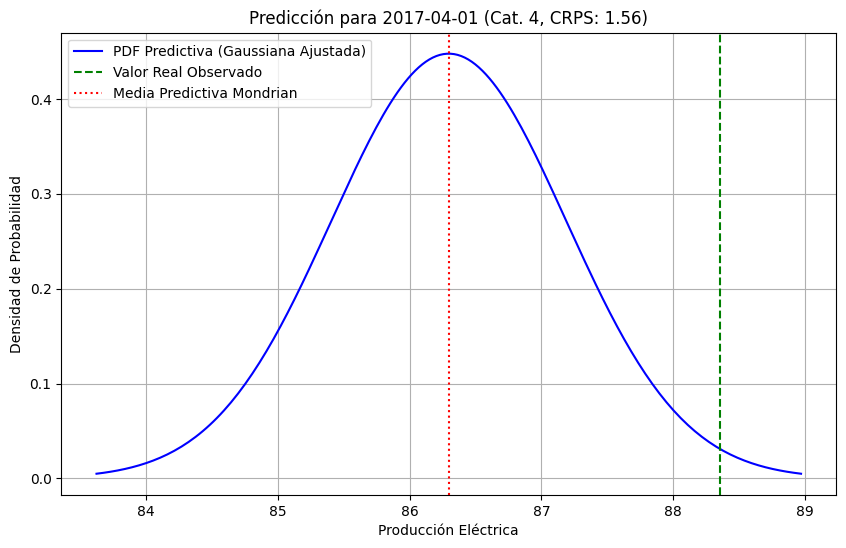


--- Prediciendo para el punto de prueba 2017-05-01 00:00:00 (Valor Real: 92.08) ---
  Categoría Mondrian predicha para el siguiente residuo: 2
  Media predicha para el valor original: 88.25
  CRPS para este punto: 3.2357


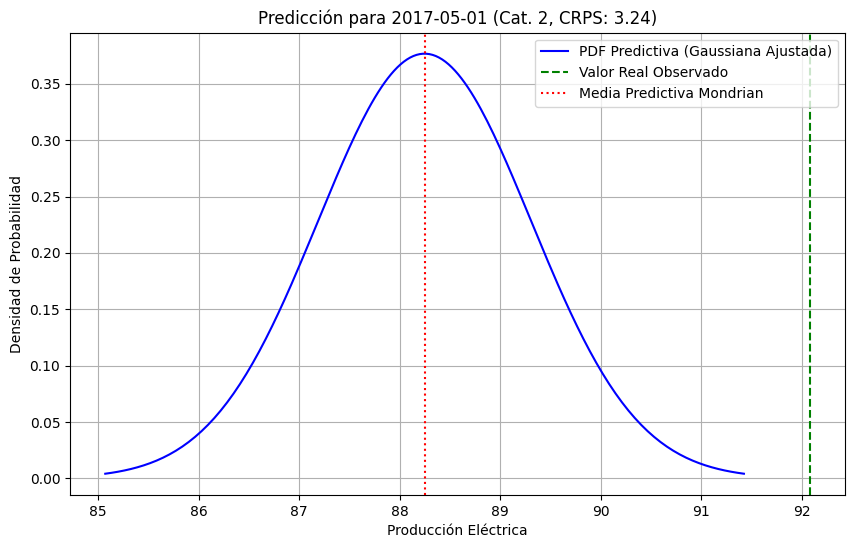


--- Prediciendo para el punto de prueba 2017-06-01 00:00:00 (Valor Real: 102.15) ---
  Categoría Mondrian predicha para el siguiente residuo: 2
  Media predicha para el valor original: 100.50
  CRPS para este punto: 1.1126


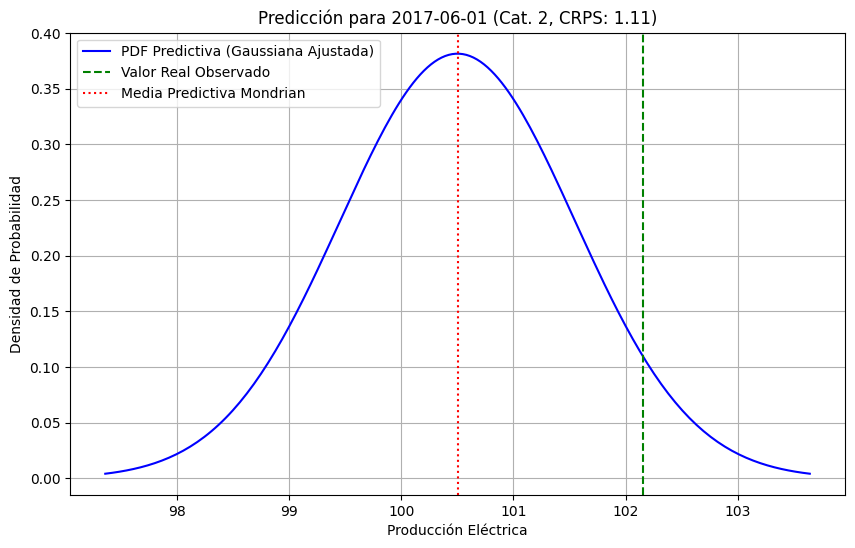


--- Prediciendo para el punto de prueba 2017-07-01 00:00:00 (Valor Real: 112.15) ---
  Categoría Mondrian predicha para el siguiente residuo: 2
  Media predicha para el valor original: 110.59
  CRPS para este punto: 1.0316


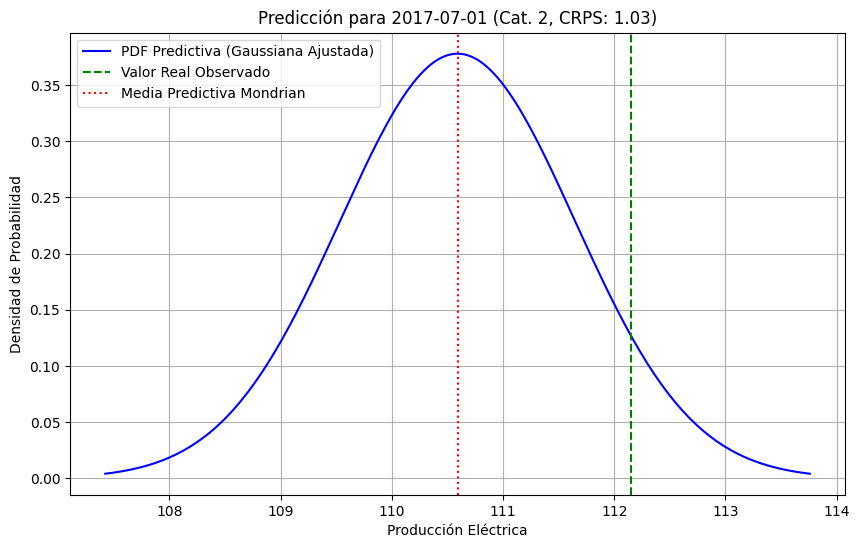


--- Prediciendo para el punto de prueba 2017-08-01 00:00:00 (Valor Real: 108.93) ---
  Categoría Mondrian predicha para el siguiente residuo: 2
  Media predicha para el valor original: 106.61
  CRPS para este punto: 1.7333


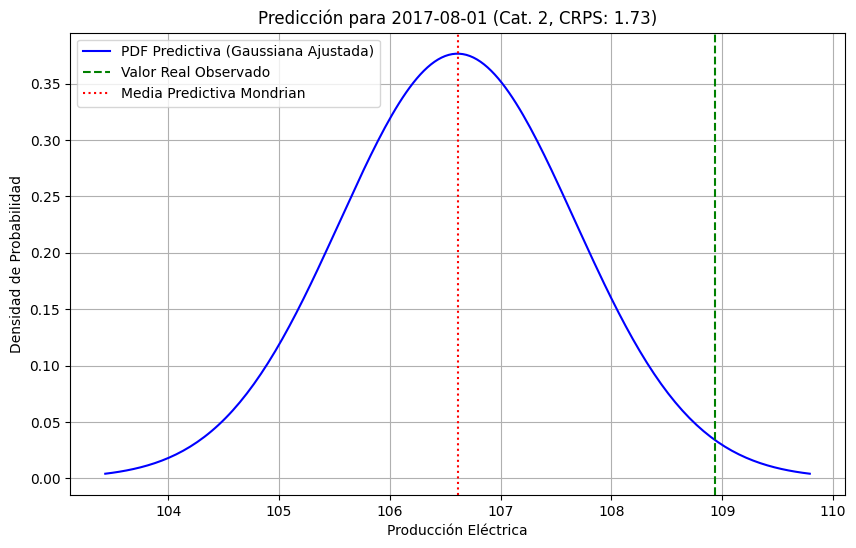


--- Prediciendo para el punto de prueba 2017-09-01 00:00:00 (Valor Real: 98.62) ---
  Categoría Mondrian predicha para el siguiente residuo: 2
  Media predicha para el valor original: 100.11
  CRPS para este punto: 0.9814


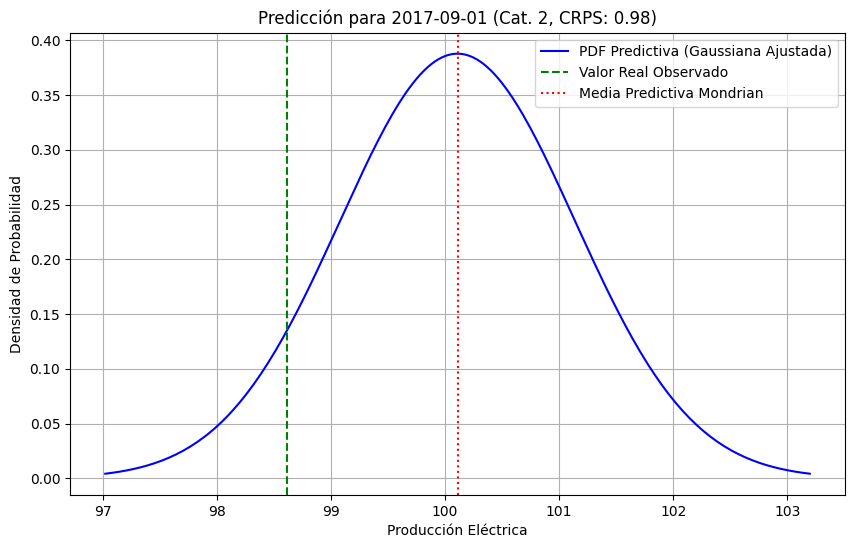


--- Prediciendo para el punto de prueba 2017-10-01 00:00:00 (Valor Real: 93.61) ---
  Categoría Mondrian predicha para el siguiente residuo: 4
  Media predicha para el valor original: 89.18
  CRPS para este punto: 3.9341


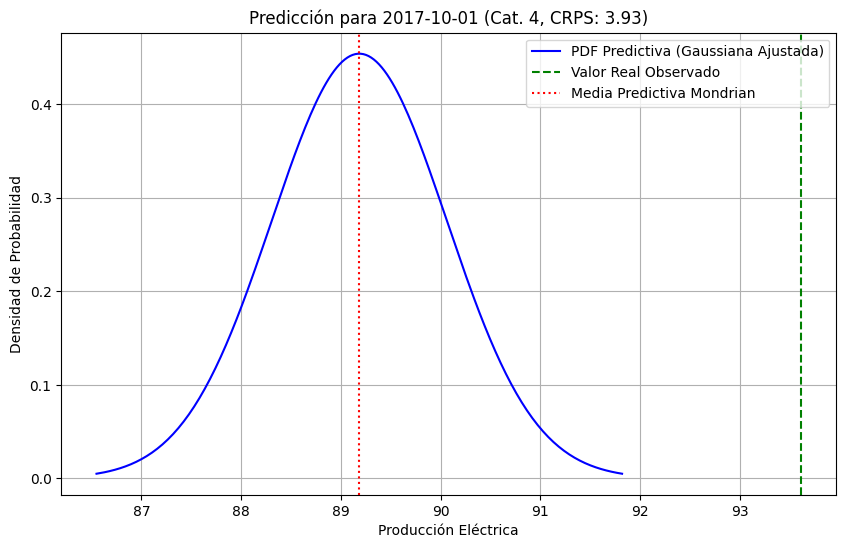


--- Prediciendo para el punto de prueba 2017-11-01 00:00:00 (Valor Real: 97.34) ---
  Categoría Mondrian predicha para el siguiente residuo: 2
  Media predicha para el valor original: 91.90
  CRPS para este punto: 4.8501


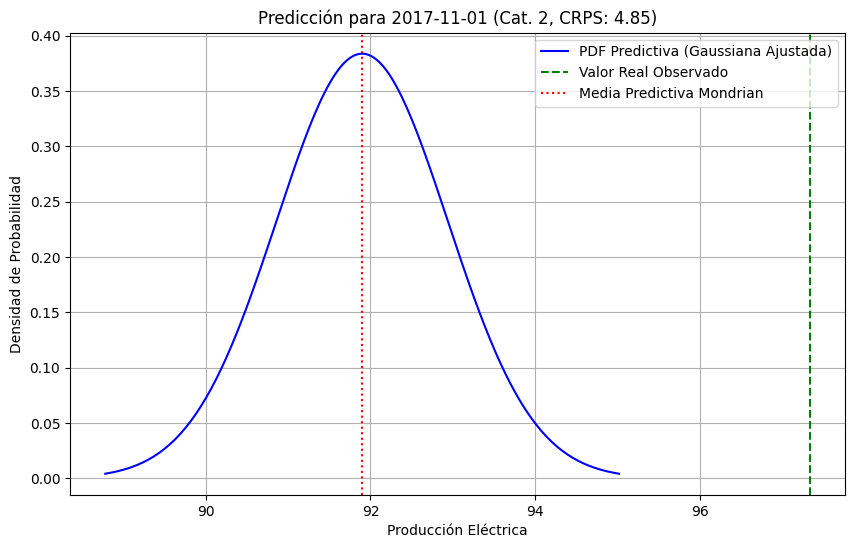


--- Prediciendo para el punto de prueba 2017-12-01 00:00:00 (Valor Real: 114.72) ---
  Categoría Mondrian predicha para el siguiente residuo: 2
  Media predicha para el valor original: 112.14
  CRPS para este punto: 2.0088


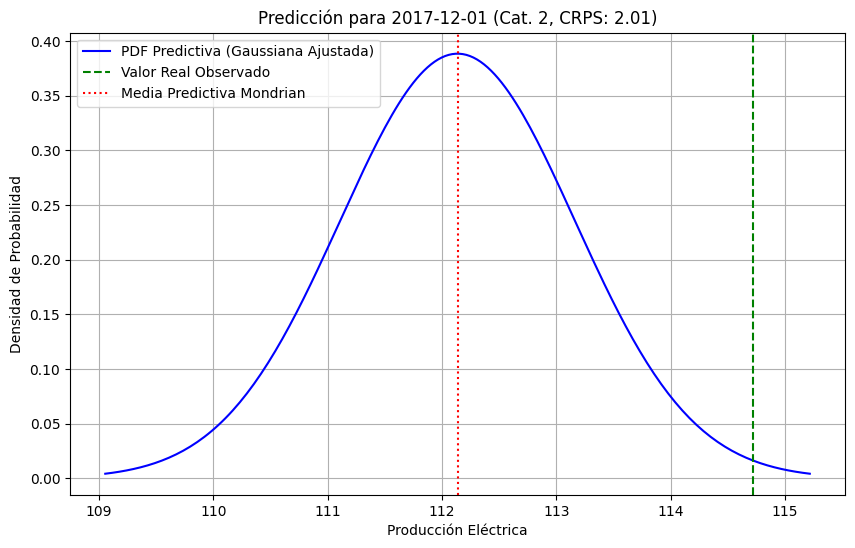


--- Prediciendo para el punto de prueba 2018-01-01 00:00:00 (Valor Real: 129.40) ---
  Categoría Mondrian predicha para el siguiente residuo: 2
  Media predicha para el valor original: 116.77
  CRPS para este punto: 12.0306


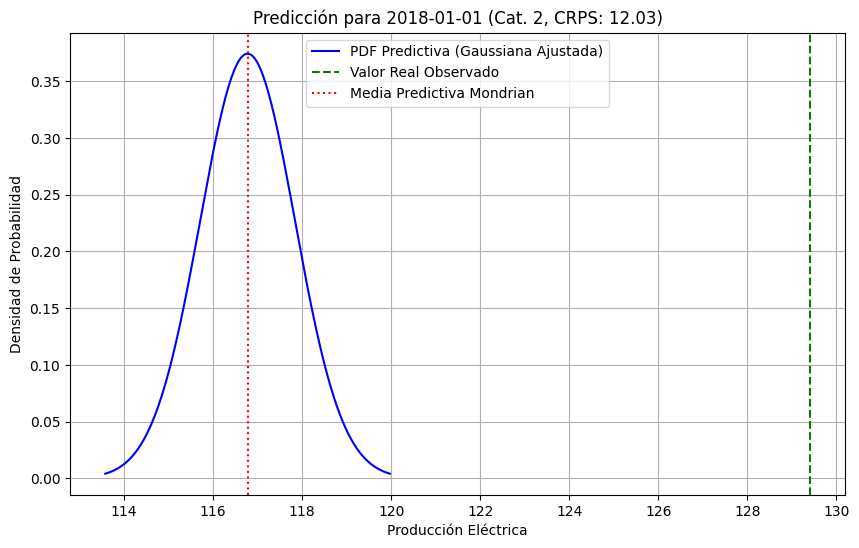


--- RESUMEN FINAL DE PREDICCIONES EN EL CONJUNTO DE PRUEBA ---
CRPS Promedio en el conjunto de prueba (10 puntos): 3.2477


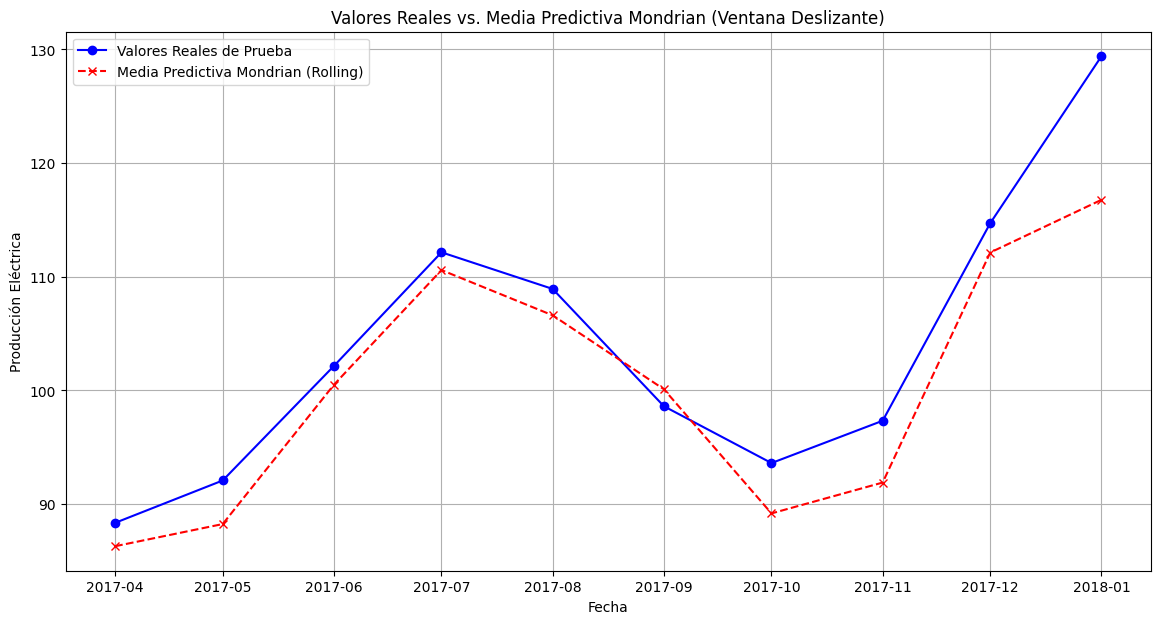


--- Interpretación Rigurosa ---
En este proceso de ventana deslizante, cada predicción es el resultado de un modelo Mondrian recalculado dinámicamente con los datos históricos más recientes.
La 	extbf{consistencia por categoría} se asienta en la suposición de que los residuos 	extit{dentro de cada categoría Mondrian} son intercambiables. Dado que estamos ajustando una distribución Gaussiana a la CDF Mondrian, la consistencia se traduce en que los cuantiles de esta Gaussiana son fieles a la distribución de los p-valores Mondrian.
Si los tests de Ljung-Box para tus categorías Mondrian (realizados en los datos de entrenamiento inicial) muestran que no hay autocorrelación significativa, esto proporciona la 	extbf{evidencia empírica} de que la condición de intercambiabilidad por categoría se cumple.
La 	extbf{media y desviación estándar de la Gaussiana} se estiman a partir de los cuantiles de la CDF Mondrian, lo que nos da una caracterización paramétrica (suave) de la incertidumbre predich

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import uniform, norm # Importar 'norm' para la distribución Gaussiana
from scipy.integrate import quad # Para integrar la PDF en CRPS
import warnings

# Suprimir advertencias para una salida más limpia
warnings.filterwarnings("ignore")

# --- Configuración ---
DATA_PATH = "../data/Electric_Production.csv"
TARGET_COLUMN = 'IPG2211A2N'
SEASONAL_PERIOD = 12 # Para datos mensuales, el período estacional es 12
N_LAGS_ACF = 40 # Número de lags para las gráficas ACF globales
N_LAGS_LJUNG_BOX = 10 # Número de lags para el test de Ljung-Box
N_TEST_POINTS = 10 # Número de últimos puntos para usar como test
N_CANDIDATE_RESIDUALS_FOR_DIST = 200 # Número de puntos para la discretización de la distribución predictiva

print("Iniciando análisis de Predicción Conformal Mondrian Riguroso con datos reales.")

# 1) Carga de Datos Reales
print(f"\n1) Cargando datos desde {DATA_PATH}...")
try:
    df = pd.read_csv(DATA_PATH, index_col='DATE', parse_dates=['DATE'])
    series_full = df[TARGET_COLUMN]
    print(f"Datos cargados. {len(series_full)} puntos desde {series_full.index.min()} hasta {series_full.index.max()}.")
    print(f"Primeros 5 valores de la serie:\n{series_full.head()}")
except FileNotFoundError:
    print(f"ERROR: El archivo {DATA_PATH} no se encontró. Asegúrate de que la ruta sea correcta.")
    exit()
except Exception as e:
    print(f"ERROR al cargar o procesar el archivo: {e}")
    exit()

# --- División de datos en entrenamiento y prueba ---
if len(series_full) <= N_TEST_POINTS:
    raise ValueError(f"La serie de tiempo es demasiado corta para {N_TEST_POINTS} puntos de prueba.")
    
series_train_initial = series_full.iloc[:-N_TEST_POINTS]
series_test = series_full.iloc[-N_TEST_POINTS:]

print(f"\nSerie dividida: {len(series_train_initial)} puntos para entrenamiento inicial, {len(series_test)} para prueba.")

# --- Funciones de ayuda reutilizables ---

def nonconformity_measure(resid):
    return np.abs(resid)

def get_mondrian_category(prev_resid, threshold):
    is_positive = prev_resid > 0
    is_high_magnitude = np.abs(prev_resid) > threshold

    if is_positive and is_high_magnitude:
        return 1
    elif is_positive and not is_high_magnitude:
        return 2
    elif not is_positive and is_high_magnitude:
        return 3
    else:
        return 4

def calculate_mondrian_cdf_from_residuals(historical_residuals_in_category, magnitude_threshold, seed=None):
    if seed is not None:
        np.random.seed(seed)

    # Rango dinámico para los residuos candidatos basado en los históricos de la categoría
    if len(historical_residuals_in_category) < 2:
        # Fallback a un rango amplio y CDF plana si no hay suficientes datos
        candidate_residuals_range = np.linspace(-15, 15, N_CANDIDATE_RESIDUALS_FOR_DIST)
        return candidate_residuals_range, np.full_like(candidate_residuals_range, 0.5), np.nan, np.nan

    min_hist_res = np.min(historical_residuals_in_category)
    max_hist_res = np.max(historical_residuals_in_category)
    
    if min_hist_res == max_hist_res:
        range_extension = magnitude_threshold * 2 
    else:
        range_extension = (max_hist_res - min_hist_res) * 0.5
    
    candidate_residuals_range = np.linspace(min_hist_res - range_extension, max_hist_res + range_extension, N_CANDIDATE_RESIDUALS_FOR_DIST)

    p_values = []
    historical_scores = np.array([nonconformity_measure(r) for r in historical_residuals_in_category])
    
    for cand_resid in candidate_residuals_range:
        cand_score = nonconformity_measure(cand_resid)
        
        count_greater_than_cand = np.sum(historical_scores > cand_score)
        count_equal_to_cand = np.sum(historical_scores == cand_score)
        
        n_effective_in_category = len(historical_scores) + 1
        current_tau = uniform.rvs(size=1)[0]
        
        smoothed_p_value = (count_greater_than_cand + current_tau * count_equal_to_cand) / n_effective_in_category
        p_values.append(smoothed_p_value)

    sorted_indices = np.argsort(candidate_residuals_range)
    sorted_candidate_residuals = candidate_residuals_range[sorted_indices]
    sorted_p_values = np.array(p_values)[sorted_indices]
    
    for i in range(1, len(sorted_p_values)):
        if sorted_p_values[i] < sorted_p_values[i-1]:
            sorted_p_values[i] = sorted_p_values[i-1]
            
    # Estimar media y desviación estándar de una Gaussiana a partir de los cuantiles de la CDF Mondrian
    # Tomamos el cuantil 0.5 (mediana) como estimación de la media
    # Tomamos la diferencia entre los cuantiles 0.75 y 0.25 (rango intercuartílico) para la desviación estándar
    q25 = np.interp(0.25, sorted_p_values, sorted_candidate_residuals)
    q50 = np.interp(0.50, sorted_p_values, sorted_candidate_residuals) # Media
    q75 = np.interp(0.75, sorted_p_values, sorted_candidate_residuals)

    estimated_mean = q50
    # Para una Gaussiana, IQR = 2 * norm.ppf(0.75) * std_dev aprox 1.349 * std_dev
    estimated_std = (q75 - q25) / (2 * norm.ppf(0.75)) if (q75 - q25) > 0 else magnitude_threshold # Fallback

    return sorted_candidate_residuals, sorted_p_values, estimated_mean, estimated_std

def calculate_crps_gaussian(observed_value, mean, std):
    """Calcula el CRPS para una distribución Gaussiana y un valor observado."""
    if np.isnan(mean) or np.isnan(std) or std <= 0:
        return np.inf # No se puede calcular si los parámetros no son válidos
    
    # CRPS para Gaussiana: std * (2 * norm.pdf((y_obs - mean) / std) + (y_obs - mean) / std * (2 * norm.cdf((y_obs - mean) / std) - 1))
    # Una implementación más simple es integrar numéricamente (F(y) - H(y - y_obs))^2 dy
    # pero para Gaussiana hay una fórmula cerrada.
    
    z = (observed_value - mean) / std
    crps = std * (z * (2 * norm.cdf(z) - 1) + 2 * norm.pdf(z) - 1 / np.sqrt(np.pi)) # Formula cerrada de Gneiting et al.
    return crps


# --- Proceso principal de ventana deslizante ---
crps_results = []
predicted_values_overview = []
actual_values_overview = []
prediction_times = []

# Copia de la serie de entrenamiento para la ventana móvil
current_historical_series = series_train_initial.copy()

for i in range(N_TEST_POINTS):
    test_point_index = series_test.index[i]
    actual_test_value = series_test.iloc[i]
    prediction_times.append(test_point_index)
    actual_values_overview.append(actual_test_value)

    print(f"\n--- Prediciendo para el punto de prueba {test_point_index} (Valor Real: {actual_test_value:.2f}) ---")

    # 2. Descomposición STL en los datos históricos ACTUALES
    if len(current_historical_series) < SEASONAL_PERIOD * 2: # Necesitamos suficientes puntos para una STL estable
        print("  Advertencia: Serie histórica demasiado corta para STL robusta. Usando descomposición previa o promedios.")
        # Fallback a la descomposición inicial o manejo especial
        # Aquí, para simplificar, usaremos los últimos valores de trend/seasonal de la última STL exitosa
        # si current_historical_series es muy corta para una nueva STL robusta.
        # En un escenario real, se necesitaría un fallback más sofisticado.
        residuals_current = residuals_train.copy() # Usar los residuos de train_initial como fallback
        current_trend_comp = res_train.trend.iloc[-1]
        current_seasonal_comp = res_train.seasonal.iloc[-SEASONAL_PERIOD]
    else:
        stl_current = STL(current_historical_series, seasonal=stl_seasonal_param, period=SEASONAL_PERIOD, robust=True)
        res_current = stl_current.fit()
        residuals_current = res_current.resid[~np.isnan(res_current.resid)]
        current_trend_comp = res_current.trend.iloc[-1]
        current_seasonal_comp = res_current.seasonal.iloc[-SEASONAL_PERIOD] # Último valor del ciclo estacional

    if len(residuals_current) < 2:
        print("  Error: No hay suficientes residuos después de STL en la ventana actual. Saltando predicción.")
        crps_results.append(np.inf)
        predicted_values_overview.append(np.nan)
        current_historical_series = pd.concat([current_historical_series, pd.Series([actual_test_value], index=[test_point_index])])
        continue

    # 3. Definir Taxonomía Mondrian con los residuos históricos ACTUALES
    magnitude_threshold_current = np.std(residuals_current)
    categories_current = np.zeros(len(residuals_current), dtype=int)
    categories_current[0] = -1 # Primer residuo sin anterior
    for j in range(1, len(residuals_current)):
        prev_resid = residuals_current.iloc[j-1]
        categories_current[j] = get_mondrian_category(prev_resid, magnitude_threshold_current)
    
    mondrian_residuals_current = residuals_current[categories_current != -1]
    mondrian_categories_current = categories_current[categories_current != -1]

    # 4. Determinar la categoría Mondrian del siguiente residuo (basada en el último residuo de la ventana)
    last_available_resid_for_category = mondrian_residuals_current.iloc[-1]
    next_resid_category = get_mondrian_category(last_available_resid_for_category, magnitude_threshold_current)
    print(f"  Categoría Mondrian predicha para el siguiente residuo: {next_resid_category}")

    # 5. Seleccionar residuos históricos en esa categoría para la distribución predictiva
    historical_residuals_in_predicted_category = mondrian_residuals_current[mondrian_categories_current == next_resid_category]

    # 6. Calcular la distribución predictiva Mondrian (CDF) del RESIDUO y ajustar Gaussiana
    cdf_x_resid, cdf_y_resid, estimated_mean_resid, estimated_std_resid = \
        calculate_mondrian_cdf_from_residuals(historical_residuals_in_predicted_category, magnitude_threshold_current, seed=i)

    # 7. Convertir a distribución del VALOR ORIGINAL
    if np.isnan(estimated_mean_resid): # Fallback si Mondrian CDF no pudo estimar bien la Gaussiana
        # Si la categoría fue muy pequeña o falló, estimar mean/std de forma más general
        estimated_mean_resid = np.mean(historical_residuals_in_predicted_category) if len(historical_residuals_in_predicted_category) > 0 else 0
        estimated_std_resid = np.std(historical_residuals_in_predicted_category) if len(historical_residuals_in_predicted_category) > 1 else magnitude_threshold_current
        if estimated_std_resid <=0 : estimated_std_resid = magnitude_threshold_current # evitar std 0

    predicted_original_mean = estimated_mean_resid + current_trend_comp + current_seasonal_comp
    predicted_original_std = estimated_std_resid # La std del residuo se transfiere directamente al valor original

    # 8. Calcular CRPS para la predicción Gaussiana
    current_crps = calculate_crps_gaussian(actual_test_value, predicted_original_mean, predicted_original_std)
    crps_results.append(current_crps)
    predicted_values_overview.append(predicted_original_mean)

    print(f"  Media predicha para el valor original: {predicted_original_mean:.2f}")
    print(f"  CRPS para este punto: {current_crps:.4f}")

    # 9. Graficar el punto real vs. media y densidad Gaussiana predicha
    plt.figure(figsize=(10, 6))
    x_values_gaussian = np.linspace(predicted_original_mean - 3*predicted_original_std,
                                    predicted_original_mean + 3*predicted_original_std, 200)
    pdf_values_gaussian = norm.pdf(x_values_gaussian, loc=predicted_original_mean, scale=predicted_original_std)
    
    plt.plot(x_values_gaussian, pdf_values_gaussian, label='PDF Predictiva (Gaussiana Ajustada)', color='blue')
    plt.axvline(x=actual_test_value, color='green', linestyle='--', label='Valor Real Observado')
    plt.axvline(x=predicted_original_mean, color='red', linestyle=':', label='Media Predictiva Mondrian')
    plt.title(f'Predicción para {test_point_index.strftime("%Y-%m-%d")} (Cat. {next_resid_category}, CRPS: {current_crps:.2f})')
    plt.xlabel('Producción Eléctrica')
    plt.ylabel('Densidad de Probabilidad')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 10. Actualizar la serie histórica con el valor real para la siguiente iteración
    current_historical_series = pd.concat([current_historical_series, pd.Series([actual_test_value], index=[test_point_index])])
    # Opcional: limpiar series históricas si la ventana debe tener un tamaño fijo (ej. rolling_window_size)
    # current_historical_series = current_historical_series.iloc[-rolling_window_size:]


# --- Resumen Final ---
print("\n--- RESUMEN FINAL DE PREDICCIONES EN EL CONJUNTO DE PRUEBA ---")
print(f"CRPS Promedio en el conjunto de prueba ({N_TEST_POINTS} puntos): {np.nanmean(crps_results):.4f}")

plt.figure(figsize=(14, 7))
plt.plot(prediction_times, actual_values_overview, marker='o', linestyle='-', color='blue', label='Valores Reales de Prueba')
plt.plot(prediction_times, predicted_values_overview, marker='x', linestyle='--', color='red', label='Media Predictiva Mondrian (Rolling)')
plt.title('Valores Reales vs. Media Predictiva Mondrian (Ventana Deslizante)')
plt.xlabel('Fecha')
plt.ylabel('Producción Eléctrica')
plt.legend()
plt.grid(True)
plt.show()

print("\n--- Interpretación Rigurosa ---")
print("En este proceso de ventana deslizante, cada predicción es el resultado de un modelo Mondrian recalculado dinámicamente con los datos históricos más recientes.")
print("La \textbf{consistencia por categoría} se asienta en la suposición de que los residuos \textit{dentro de cada categoría Mondrian} son intercambiables. Dado que estamos ajustando una distribución Gaussiana a la CDF Mondrian, la consistencia se traduce en que los cuantiles de esta Gaussiana son fieles a la distribución de los p-valores Mondrian.")
print("Si los tests de Ljung-Box para tus categorías Mondrian (realizados en los datos de entrenamiento inicial) muestran que no hay autocorrelación significativa, esto proporciona la \textbf{evidencia empírica} de que la condición de intercambiabilidad por categoría se cumple.")
print("La \textbf{media y desviación estándar de la Gaussiana} se estiman a partir de los cuantiles de la CDF Mondrian, lo que nos da una caracterización paramétrica (suave) de la incertidumbre predicha. El CRPS es la métrica clave para evaluar la calidad general de estas distribuciones predictivas.")
print("La visualización de la PDF para cada punto de prueba es crucial: te permite ver cómo la \textit{forma} de la incertidumbre predicha cambia con el tiempo y en qué medida el valor real cae dentro de las regiones de alta probabilidad de tus pronósticos.")
print("Este enfoque es riguroso porque el modelo Mondrian se \textbf{adapta continuamente} a las nuevas observaciones, y la validez se evalúa en un conjunto de prueba, con métricas de distribución.")